In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer,LabelEncoder

from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc 


import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings("ignore")

C:\Users\Ni Qie\anaconda3\lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [3]:
df = pd.read_csv(r'C:\Users\Ni Qie\Desktop\springboard\capstone2-final\data\WA_Fn-UseC_-Telco-Customer-Churn_cleaned.csv')

Now we can explore the distribution of labels across different features to preliminarily investigate which features have a significant impact on label values. Of course, we can first examine the distribution of values in the label field:

In [4]:
y = df['Churn']
print(f'Percentage of Churn:  {round(y.value_counts(normalize=True)[1]*100,2)} %  --> ({y.value_counts()[1]} customer)\nPercentage of customer did not churn: {round(y.value_counts(normalize=True)[0]*100,2)}  %  --> ({y.value_counts()[0]} customer)')

Percentage of Churn:  26.54 %  --> (1869 customer)
Percentage of customer did not churn: 73.46  %  --> (5174 customer)


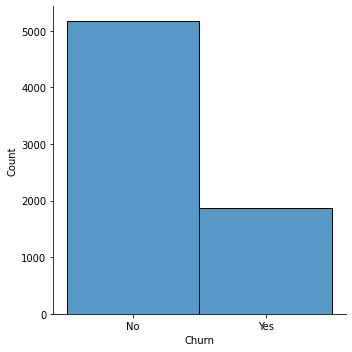

In [9]:
sns.displot(y)

So we have imbalanced data.
Almost 27% of the customers didn't continue with the company and churned.
1869 customer churned.
Almost 73% of the customers continue with the company and didn't churn.
5174 customer didn't churn

# Correlation matrix

In [11]:
# Deleting ID column
df2 = df.iloc[:,1:].copy()

# Transform the 'Churn' column from Yes/No to 1/0
df2['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df2['Churn'].replace(to_replace='No',  value=0, inplace=True)

# Transform categorical columns to dummy variables, keep numerical columns as they are
df_dummies = pd.get_dummies(df2)
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,True,False,False,True,True,...,False,True,False,False,False,True,False,False,True,False
1,0,34,56.95,1889.50,0,False,True,True,False,True,...,False,False,True,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,False,True,True,False,True,...,False,True,False,False,False,True,False,False,False,True
3,0,45,42.30,1840.75,0,False,True,True,False,True,...,False,False,True,False,True,False,True,False,False,False
4,0,2,70.70,151.65,1,True,False,True,False,True,...,False,True,False,False,False,True,False,False,True,False


In [13]:
df_dummies.corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
SeniorCitizen,1.000000,0.016567,0.220173,0.102395,0.150889,0.001874,-0.001874,-0.016479,0.016479,0.211185,...,0.120176,0.138360,-0.046262,-0.117000,-0.156530,0.156530,-0.016159,-0.024135,0.171718,-0.153477
tenure,0.016567,1.000000,0.247900,0.824757,-0.352229,-0.005106,0.005106,-0.379697,0.379697,-0.159712,...,0.286111,-0.645561,0.202570,0.558533,-0.006152,0.006152,0.243510,0.233006,-0.208363,-0.233852
MonthlyCharges,0.220173,0.247900,1.000000,0.650468,0.193356,0.014569,-0.014569,-0.096848,0.096848,0.113890,...,0.627429,0.060165,0.004904,-0.074681,-0.352150,0.352150,0.042812,0.030550,0.271625,-0.377437
TotalCharges,0.102395,0.824757,0.650468,1.000000,-0.199428,-0.000048,0.000048,-0.318812,0.318812,-0.064535,...,0.519574,-0.446348,0.170491,0.357224,-0.157676,0.157676,0.185992,0.182581,-0.060412,-0.294125
Churn,0.150889,-0.352229,0.193356,-0.199428,1.000000,0.008612,-0.008612,0.150448,-0.150448,0.164221,...,0.061382,0.405103,-0.177820,-0.302253,-0.191825,0.191825,-0.117937,-0.134302,0.301919,-0.091683
gender_Female,0.001874,-0.005106,0.014569,-0.000048,0.008612,1.000000,-1.000000,-0.001808,0.001808,0.010517,...,0.010487,0.003386,-0.008026,0.003695,-0.011754,0.011754,0.016024,-0.001215,-0.000752,-0.013744
gender_Male,-0.001874,0.005106,-0.014569,0.000048,-0.008612,-1.000000,1.000000,0.001808,-0.001808,-0.010517,...,-0.010487,-0.003386,0.008026,-0.003695,0.011754,-0.011754,-0.016024,0.001215,0.000752,0.013744
Partner_No,-0.016479,-0.379697,-0.096848,-0.318812,0.150448,-0.001808,0.001808,1.000000,-1.000000,0.452676,...,-0.117412,0.280865,-0.082783,-0.248091,-0.014877,0.014877,-0.110706,-0.082029,0.083852,0.095125
Partner_Yes,0.016479,0.379697,0.096848,0.318812,-0.150448,0.001808,-0.001808,-1.000000,1.000000,-0.452676,...,0.117412,-0.280865,0.082783,0.248091,0.014877,-0.014877,0.110706,0.082029,-0.083852,-0.095125
Dependents_No,0.211185,-0.159712,0.113890,-0.064535,0.164221,0.010517,-0.010517,0.452676,-0.452676,1.000000,...,0.039741,0.231720,-0.068368,-0.204613,-0.111377,0.111377,-0.052021,-0.060267,0.150642,-0.059071


In [14]:
df_dummies.corr()['Churn'].sort_values(ascending = False)

Churn                                      1.000000
Contract_Month-to-month                    0.405103
OnlineSecurity_No                          0.342637
TechSupport_No                             0.337281
InternetService_Fiber optic                0.308020
PaymentMethod_Electronic check             0.301919
OnlineBackup_No                            0.268005
DeviceProtection_No                        0.252481
MonthlyCharges                             0.193356
PaperlessBilling_Yes                       0.191825
Dependents_No                              0.164221
SeniorCitizen                              0.150889
Partner_No                                 0.150448
StreamingMovies_No                         0.130845
StreamingTV_No                             0.128916
StreamingTV_Yes                            0.063228
StreamingMovies_Yes                        0.061382
MultipleLines_Yes                          0.040102
PhoneService_Yes                           0.011942
gender_Femal

<Axes: >

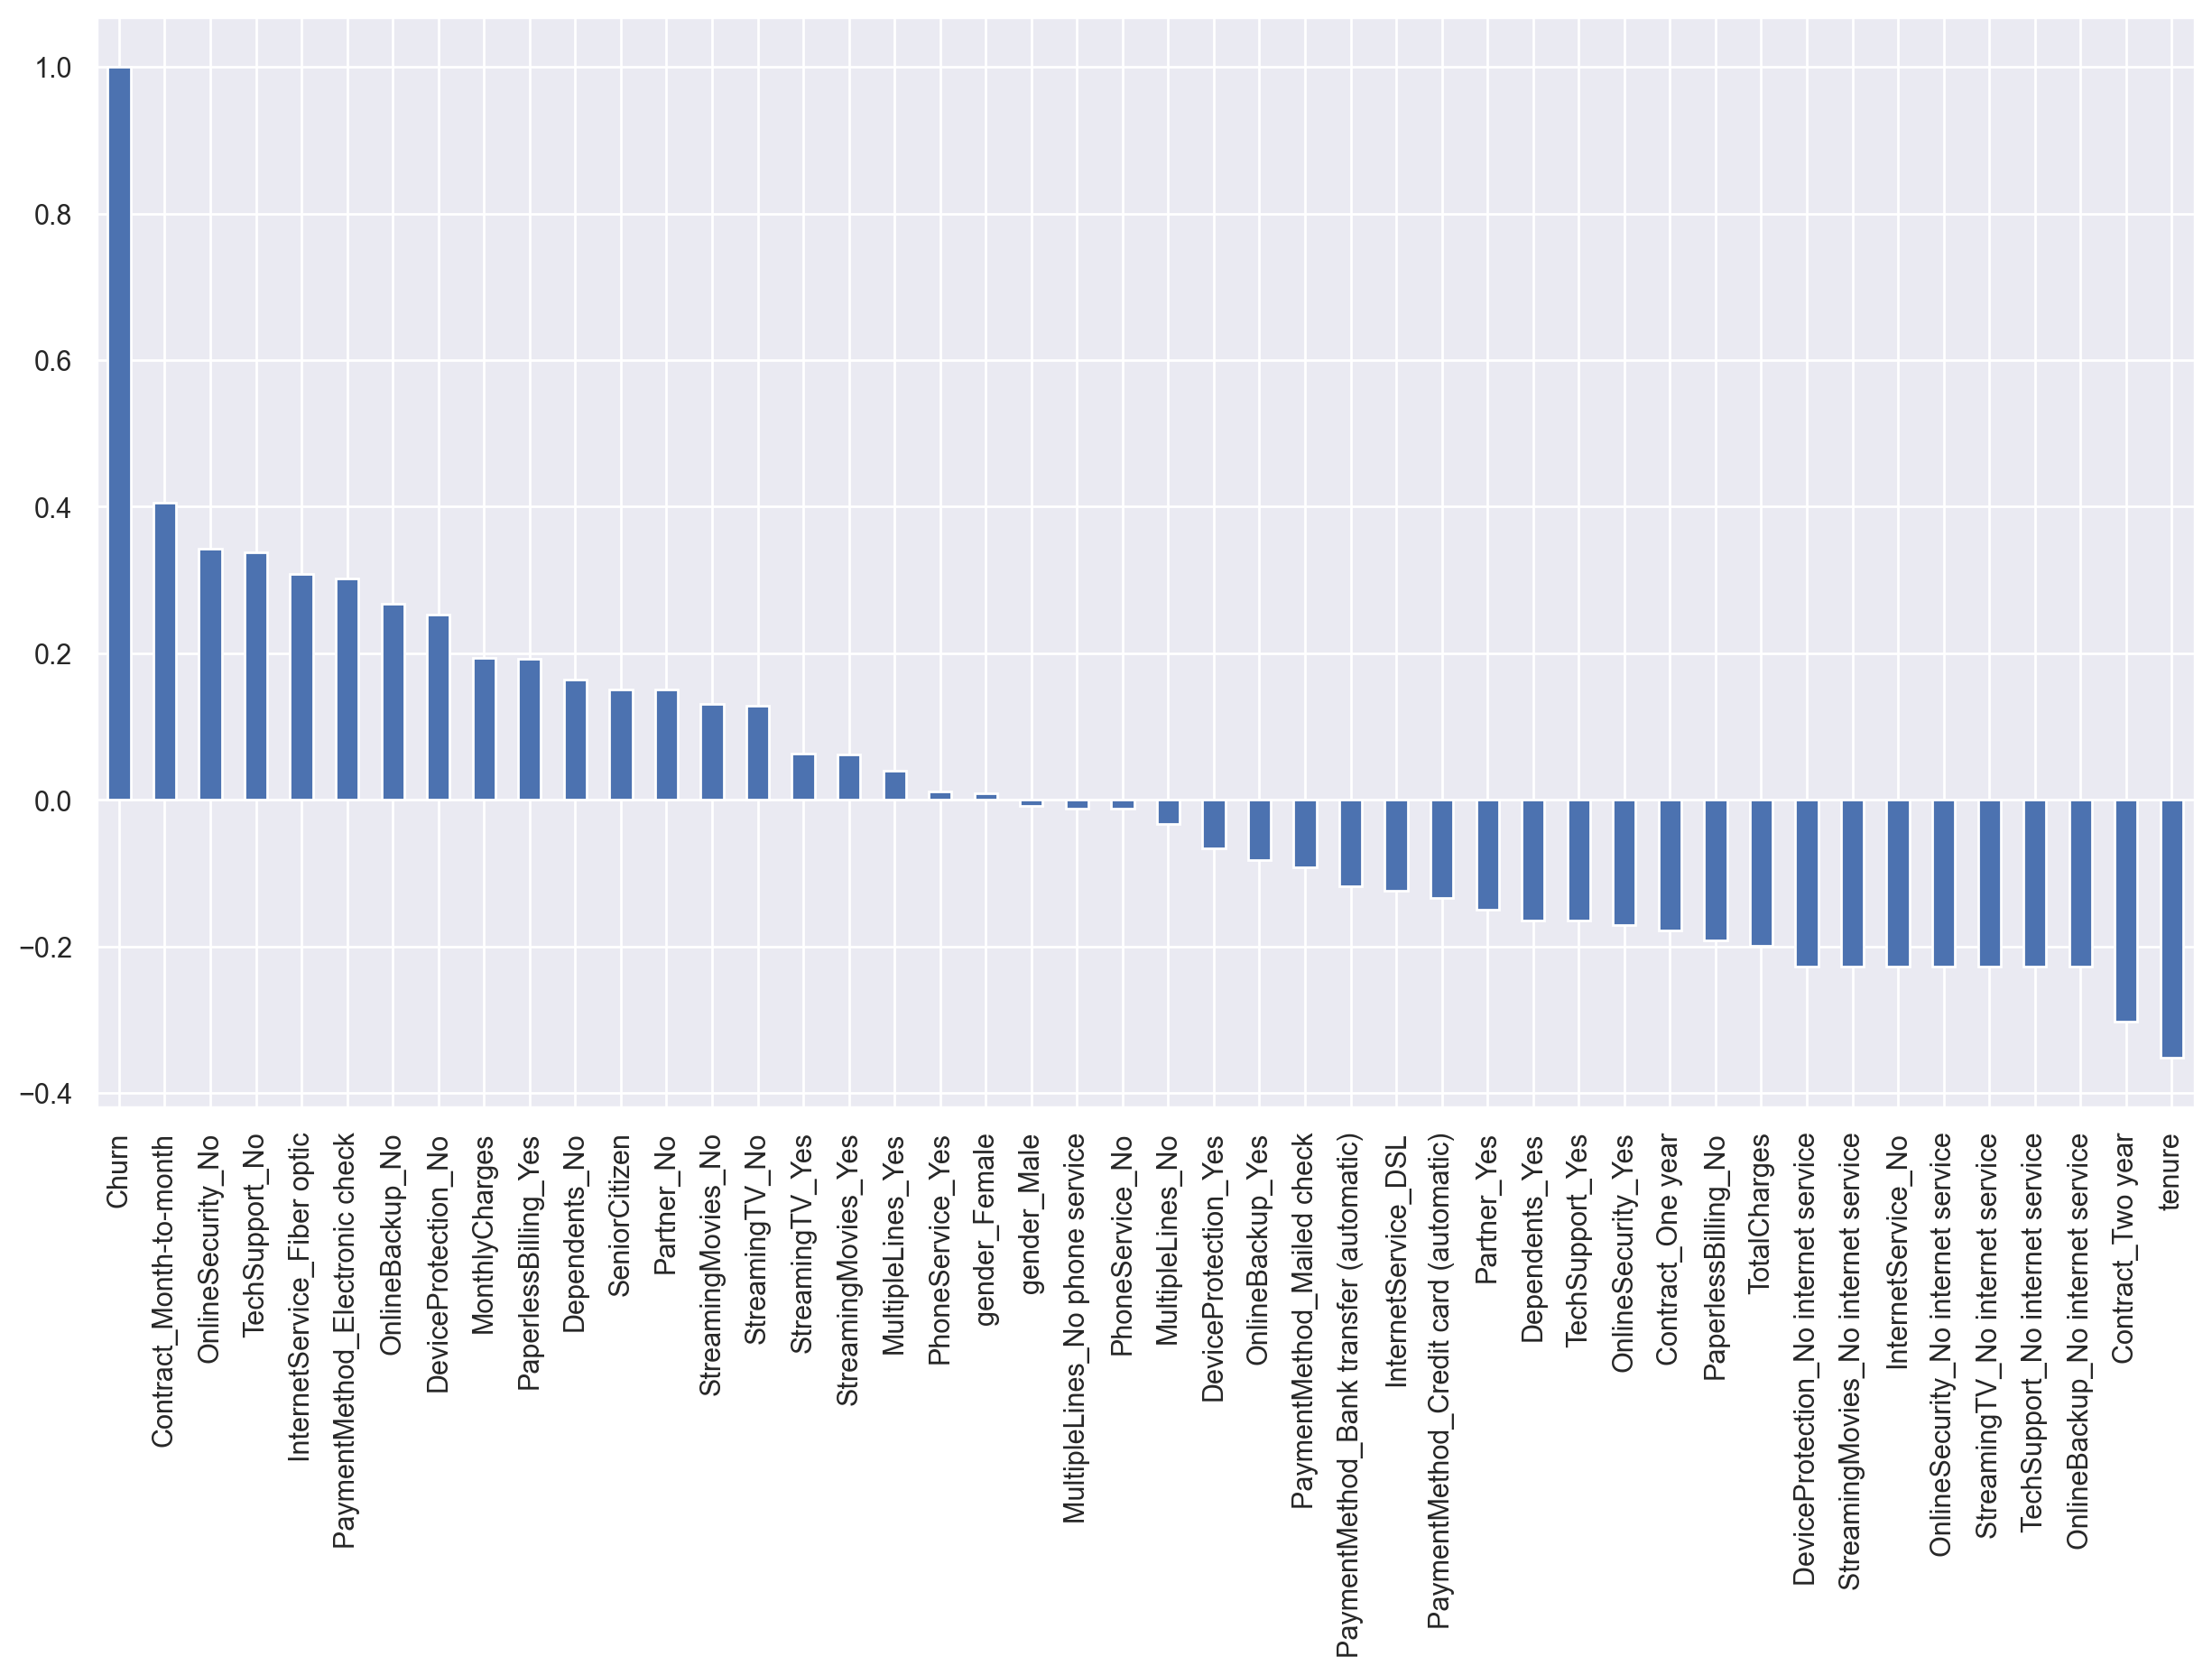

In [20]:
sns.set()
plt.figure(figsize=(15,8), dpi=200)

df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

# Bivariate analysis

Text(0.5, 1.0, 'Churn by Gender')

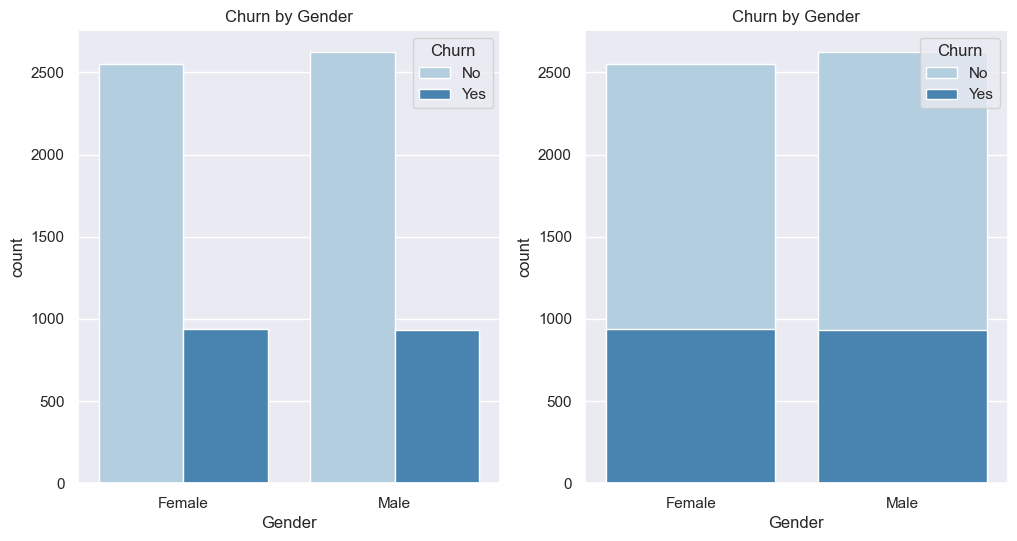

In [23]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(12,6), dpi=100)

plt.subplot(121)
sns.countplot(x="gender",hue="Churn",data=df,palette="Blues", dodge=True)
plt.xlabel("Gender")
plt.title("Churn by Gender")

plt.subplot(122)
sns.countplot(x="gender",hue="Churn",data=df,palette="Blues", dodge=False)
plt.xlabel("Gender")
plt.title("Churn by Gender")

# "gender", "SeniorCitizen", "Partner", "Dependents" and Churn

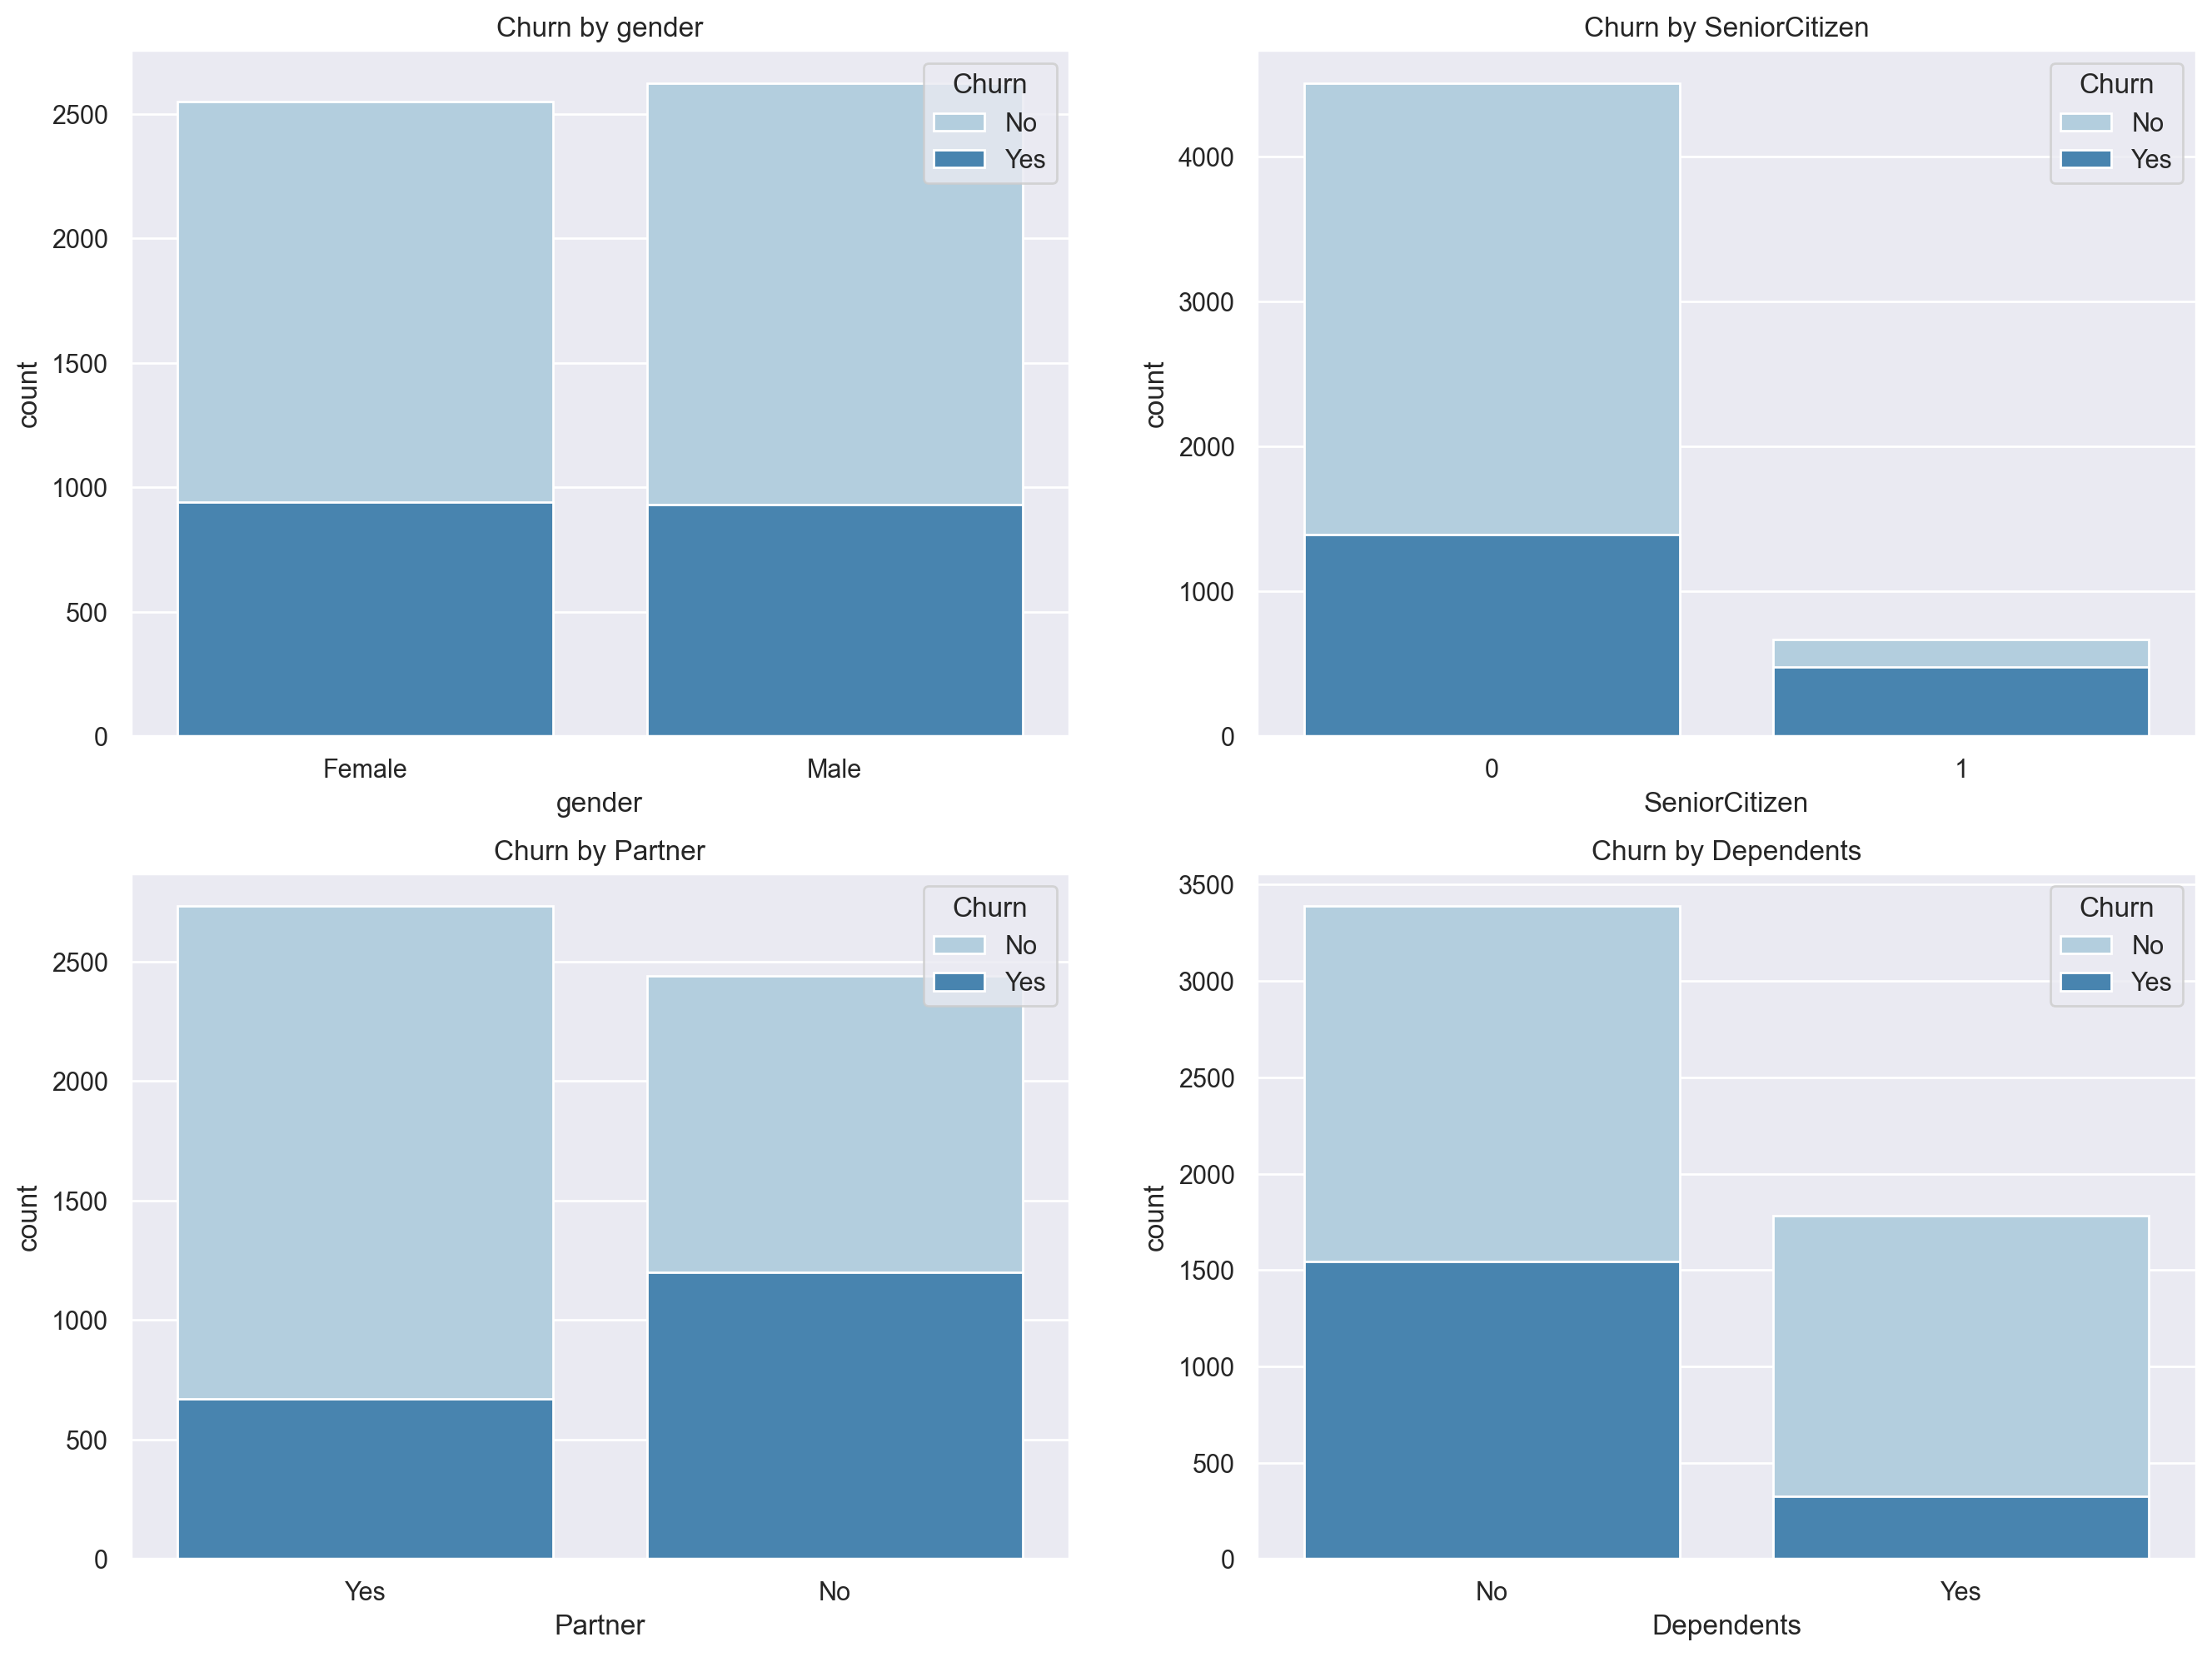

In [25]:
col_1 = ["gender", "SeniorCitizen", "Partner", "Dependents"]

fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(16,12), dpi=200)

for i, item in enumerate(col_1):
    plt.subplot(2,2,(i+1))
    ax=sns.countplot(x=item,hue="Churn",data=df,palette="Blues", dodge=False)
    plt.xlabel(item)
    plt.title("Churn by "+ item)

Senior citizens, unmarried users, and financially dependent users have relatively higher churn rates, while the gender factor has little impact on whether they churn or not. In formulating operational strategies, these three types of users need special attention.

# **"OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies" and Churn**

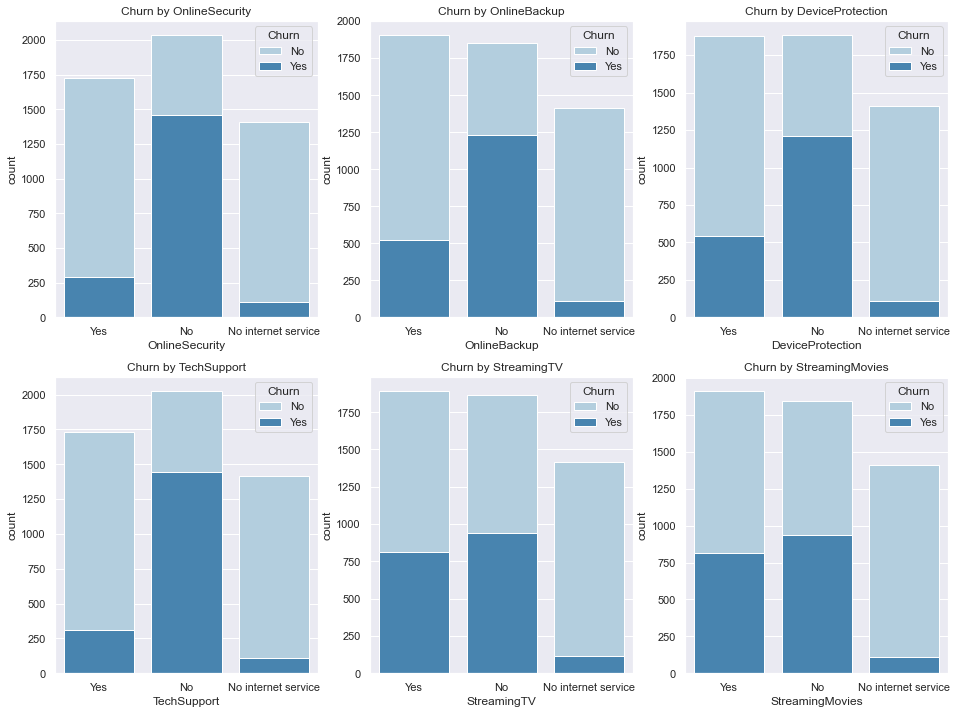

In [27]:
col_2 = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(16,12))

for i, item in enumerate(col_2):
    plt.subplot(2,3,(i+1))
    ax=sns.countplot(x=item,hue="Churn",data=df,palette="Blues",order=["Yes","No","No internet service"], dodge=False)
    plt.xlabel(item)
    plt.title("Churn by "+ item)

Users who have not subscribed to internet services, as well as those who have subscribed to internet services and also have many additional services, tend to have a lower probability of churning. In contrast, users who have subscribed to internet services but have not subscribed to other additional services have a higher probability of churning. Therefore, it could be considered to offer more opportunities for free trials of additional services, increase the promotion of these services, and encourage purchases to enhance customer retention.

# **"Contract", "PaperlessBilling", "PaymentMethod" and Churn**

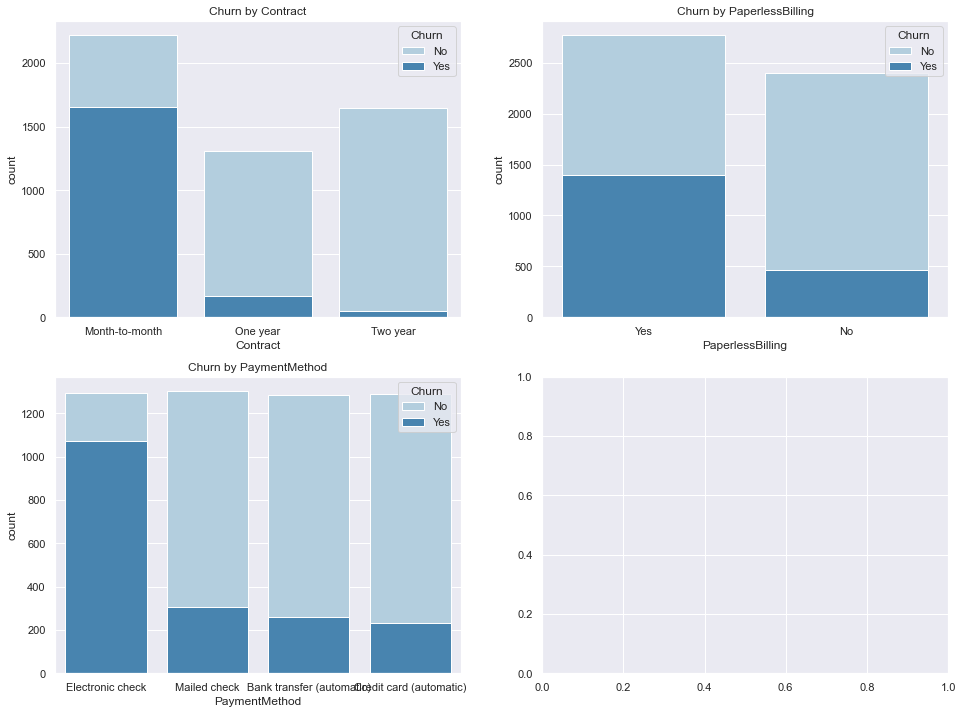

In [29]:
col_3 = ["Contract", "PaperlessBilling", "PaymentMethod"]

fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(16,12))

for i, item in enumerate(col_3):
    plt.subplot(2,2,(i+1))
    ax=sns.countplot(x=item,hue="Churn",data=df,palette="Blues", dodge=False)
    plt.xlabel(item)
    plt.title("Churn by "+ item)

Users who sign up for shorter service periods are more likely to churn, and users who pay online are more likely to churn compared to those who use other payment methods. Therefore, it might be necessary to guide users to sign longer-term contracts in actual operations, whether through discounts or gifts with purchase, thereby enhancing the customer lifecycle. In addition, it is important to pay more attention to the actual product experience of users who pay online and consider improving the user experience of online payments itself, or offering more price incentives to increase the satisfaction of users who pay online.